In [1]:
import orflib as orf
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import norm

In [3]:
rate = 0.05
curve_name = "USD"
orf.mktClear()
orf.ycCreate(curve_name, np.array([10.0]), np.array([rate]), 0) 

print(f"Market initialized with {curve_name} yield curve at {rate:.1%}")

Market initialized with USD yield curve at 5.0%


In [4]:
## We define a typical convertible bond with the following paramters 

face_value = 100.0
maturity = 1.0         
conv_ratio = 1.0       
conv_start = 0.0      
conv_end = 1.0
call_strike = 110.0    
call_start = 0.0       
call_end = 1.0

spot = 100.0
vol = 0.20              
div_yield = 0.02      

pde_params = {
    'NTIMESTEPS': 365,     
    'NSPOTNODES': 100,     
    'NSTDDEVS': 4.0,     
    'THETA': 0.5           
}

In [5]:
results = orf.cbBSPDE(
    face_value, maturity, conv_ratio, conv_start, conv_end,
    call_strike, call_start, call_end,
    spot, curve_name, div_yield, vol,
    pde_params, allresults=True
)

In [7]:
print(f"Convertible Bond Price (t=0, S={spot}): {results['Price']:.4f}")

Convertible Bond Price (t=0, S=100.0): 103.8378


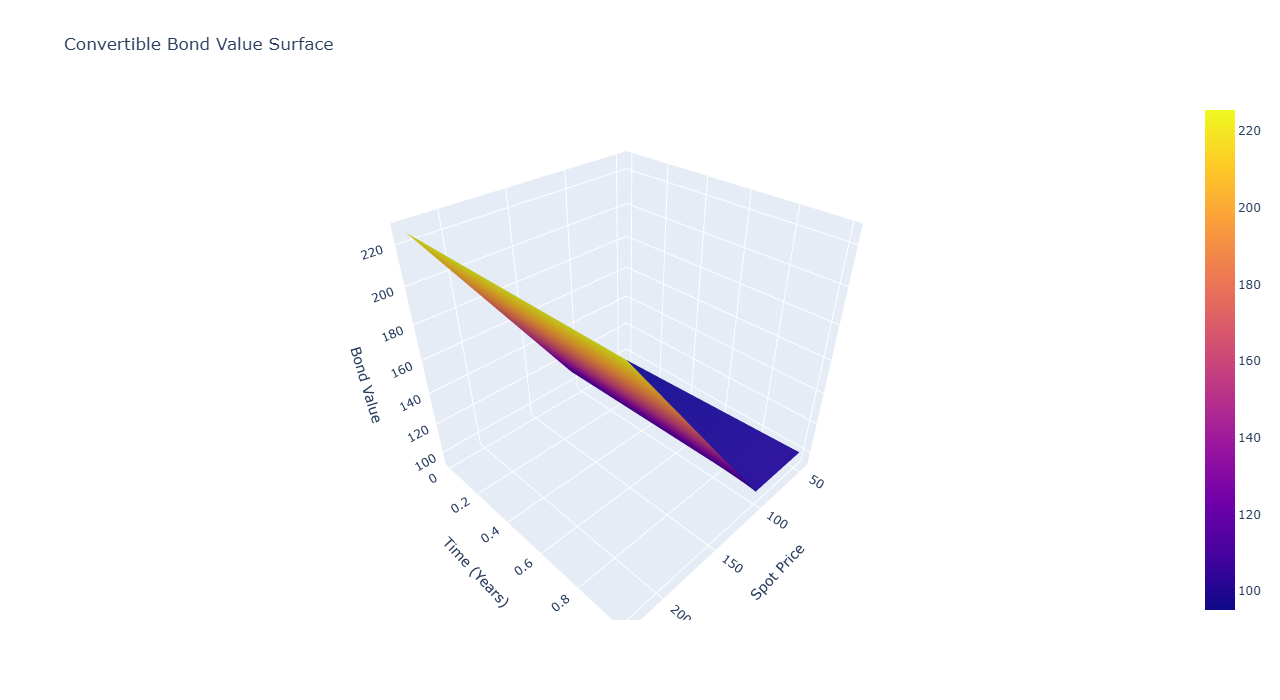

In [8]:
times = results['Times']
spots = results['Spots']
values = results['Values']

fig = go.Figure(data=[go.Surface(x=spots, y=times, z=values)])

fig.update_layout(
    title='Convertible Bond Value Surface',
    scene=dict(
        xaxis_title='Spot Price',
        yaxis_title='Time (Years)',
        zaxis_title='Bond Value'
    ),
    width=900,
    height=700
)

fig.show()

In [14]:
## Try another parameter 
face_value  = 100.0
maturity    = 5.0         
conv_ratio  = 1.5         
conv_start  = 2.0        
conv_end    = 5.0

call_strike = 105.0        
call_start  = 0.5          
call_end    = 4.0            

spot       = 80.0           
vol        = 0.50           
div_yield  = 0.06          

pde_params = {
    "NTIMESTEPS": 1000,     
    "NSPOTNODES": 300,     
    "NSTDDEVS":   5.0,     
    "THETA":      0.6     
}

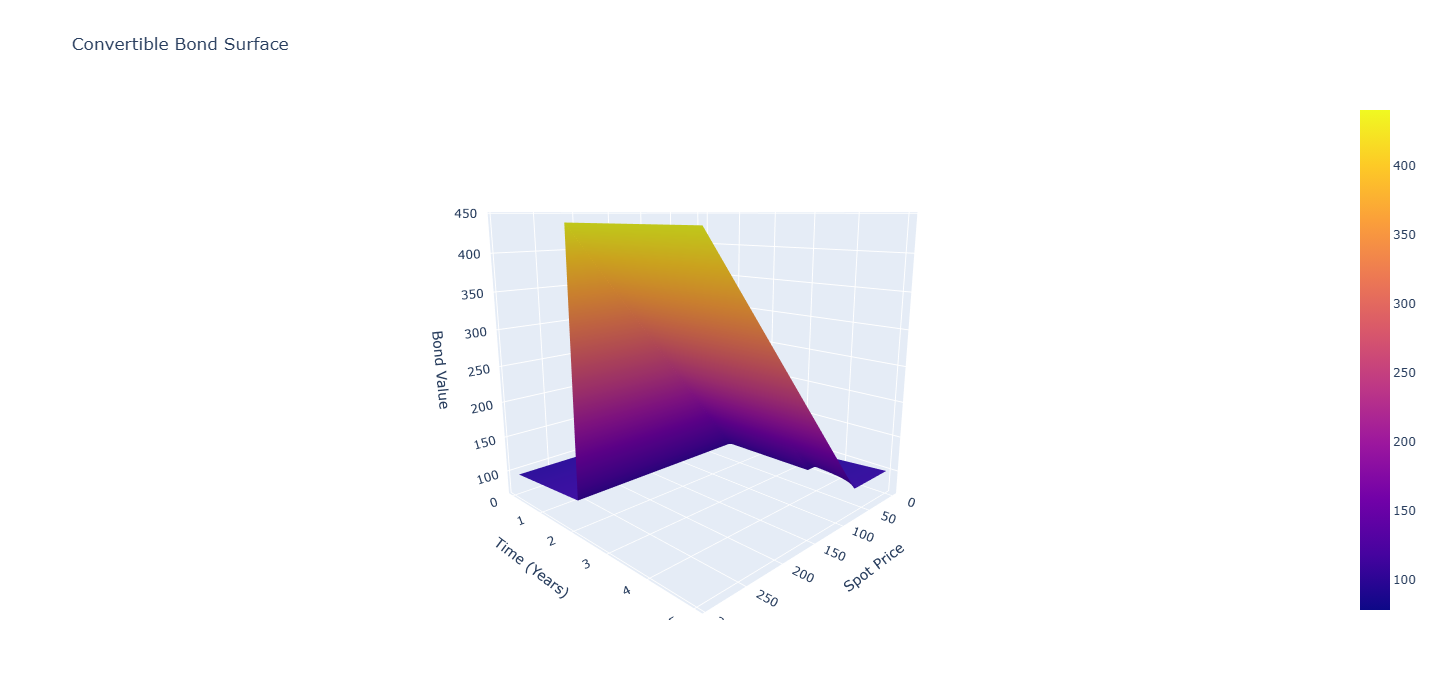

In [19]:
results2 = orf.cbBSPDE(
    face_value, maturity, conv_ratio, conv_start, conv_end,
    call_strike, call_start, call_end,
    spot, curve_name, div_yield, vol,
    pde_params, allresults=True
)

times_raw = np.array(results2['Times'])
spots_raw = np.array(results2['Spots'])
values_raw = np.array(results2['Values']) 

mask = spots_raw <= 300
spots_plot = spots_raw[mask]
values_plot = values_raw[:, mask]

# 3. Create Surface Plot
fig = go.Figure(data=[go.Surface(x=spots_plot, y=times_raw, z=values_plot)])

fig.update_layout(
    title='Convertible Bond Surface',
    scene=dict(
        xaxis_title='Spot Price',
        yaxis_title='Time (Years)',
        zaxis_title='Bond Value',
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.5))
    ),
    width=900,
    height=700
)

fig.show()

### Extract the t=0 (start of the bond) slice for the first case

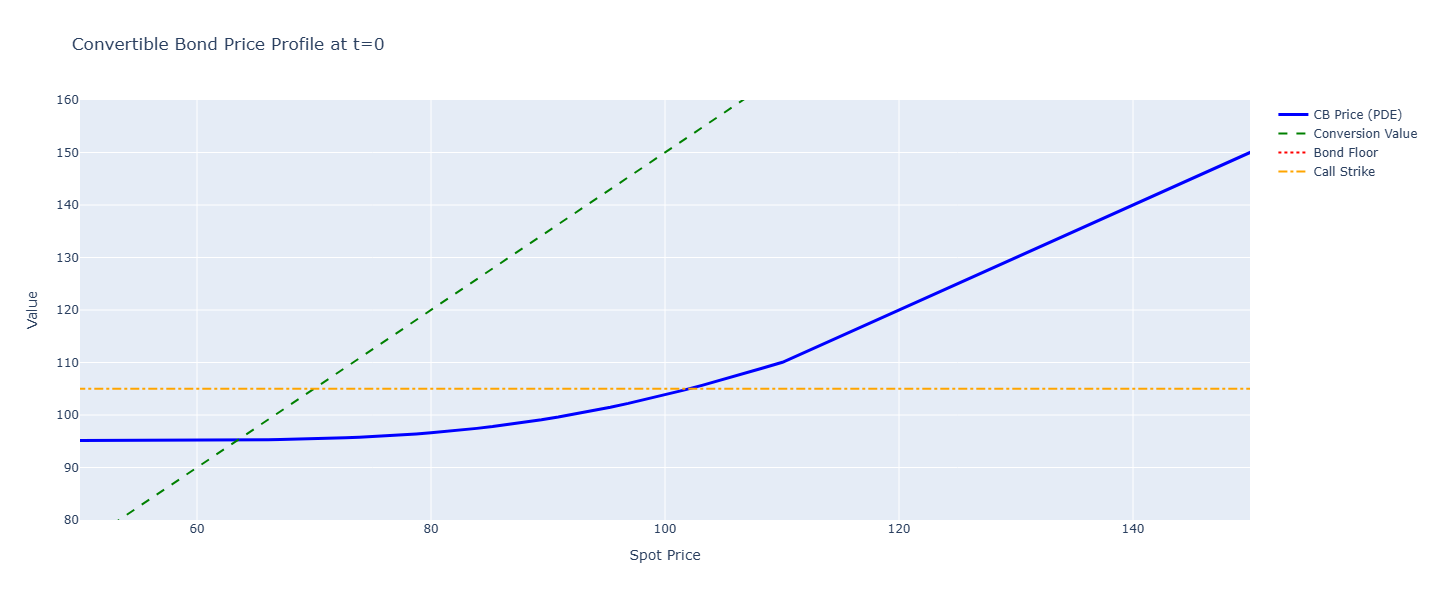

In [17]:
cb_prices_t0 = values[0, :]

bond_floor = face_value * np.exp(-rate * maturity)
equity_value = conv_ratio * spots
conversion_parity = np.maximum(bond_floor, equity_value)

fig_2d = go.Figure()
fig_2d.add_trace(go.Scatter(x=spots, y=cb_prices_t0, mode='lines', name='CB Price (PDE)', line=dict(color='blue', width=3)))
fig_2d.add_trace(go.Scatter(x=spots, y=equity_value, mode='lines', name='Conversion Value', line=dict(dash='dash', color='green')))
fig_2d.add_trace(go.Scatter(x=spots, y=[bond_floor]*len(spots), mode='lines', name='Bond Floor', line=dict(dash='dot', color='red')))
fig_2d.add_trace(go.Scatter(x=spots, y=[call_strike]*len(spots), mode='lines', name='Call Strike', line=dict(dash='dashdot', color='orange')))

fig_2d.update_layout(
    title='Convertible Bond Price Profile at t=0',
    width = 800, 
    height = 600, 
    xaxis_title='Spot Price',
    yaxis_title='Value',
    xaxis_range=[50, 150], # Zoom in on the interesting area
    yaxis_range=[80, 160]
)

fig_2d.show()

In [18]:
# --- Verification Logic ---
# Low Spot Case
low_spot_idx = 0 
print(f"\nLimiting Case Check:")
print(f"Low Spot ({spots[low_spot_idx]:.2f}): CB Price = {cb_prices_t0[low_spot_idx]:.4f} vs Bond Floor = {bond_floor:.4f}")

# High Spot Case
high_spot_idx = -1
print(f"High Spot ({spots[high_spot_idx]:.2f}): CB Price = {cb_prices_t0[high_spot_idx]:.4f} vs Conversion Value = {equity_value[high_spot_idx]:.4f}")


Limiting Case Check:
Low Spot (45.07): CB Price = 95.1228 vs Bond Floor = 77.8801
High Spot (225.46): CB Price = 225.4595 vs Conversion Value = 338.1892


## Verification for extreme case with high strike and conversion only at maturity

In [20]:
no_call_strike = 9999.0 

conv_only_at_maturity_start = maturity 
conv_only_at_maturity_end = maturity

results_euro = orf.cbBSPDE(
    face_value, maturity, conv_ratio, 
    conv_only_at_maturity_start, conv_only_at_maturity_end,
    no_call_strike, call_start, call_end,
    spot, curve_name, div_yield, vol,
    pde_params, allresults=False
)

pde_price = results_euro['Price']
pde_price

118.95137217423776

In [22]:
def bs_price(S, K, T, r, q, sigma, option_type='call'):
    """Calculates analytical European option price"""
    if T <= 0:
        return max(0, (S - K) if option_type == 'call' else (K - S))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

In [23]:
bond_component = face_value * np.exp(-rate * maturity)
effective_strike = face_value / conv_ratio
call_component = conv_ratio * bs_price(spot, effective_strike, maturity, rate, div_yield, vol, 'call')

analytical_price = bond_component + call_component
analytical_price

np.float64(118.95575244263082)

In [24]:
abs(pde_price - analytical_price)

np.float64(0.004380268393063602)